# Project Objective
Aim of this project is to determine the writer emotion based on their text that they had written.
We will use Natural Process Language to different the different types of emotions.

Emotions are classified into six categories: 
1. Sadness (0)
2. Joy (1)
3. Love (2)
4. Anger (3) 
5. Fear (4) 
6. Surprise (5)

In [206]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

In [2]:
origin_dataset = pd.read_csv("raw_data/text_emotion_Dataset.csv")

## Data Exploration

### Raw data

In [38]:
print(f"Raw data consist of: {origin_dataset.shape[0]} rows")
print(f"Raw data consist of: {origin_dataset.shape[1]} columns")

Raw data consist of: 416809 rows
Raw data consist of: 3 columns


In [39]:
origin_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


In [40]:
origin_dataset.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [41]:
origin_dataset[origin_dataset.duplicated()] # Good that we don't have duplicate rows or dulicapted dataset

,Unnamed: 0,text,label


In [45]:
origin_dataset['label'].value_counts()

1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: label, dtype: int64

In [47]:
origin_dataset.isnull().sum()

Unnamed: 0    0
text          0
label         0
dtype: int64

## Data wraggling/Cleaning

In [233]:
emotion_dataset = origin_dataset[['text','label']].copy()
emotion_dataset['label'] = emotion_dataset['label'].astype('category')
emotion_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   text    416809 non-null  object  
 1   label   416809 non-null  category
dtypes: category(1), object(1)
memory usage: 3.6+ MB


In [15]:
emotion_dataset.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


## Data Analysis

In [27]:
label_mapping = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}
emotion_dataset['emotion_label'] = emotion_dataset['label'].map(label_mapping)

In [29]:
emotion_dataset['emotion_label'].value_counts()

Joy         141067
Sadness     121187
Anger        57317
Fear         47712
Love         34554
Surprise     14972
Name: emotion_label, dtype: int64

In [56]:
emotion_dataset['word_length'] = emotion_dataset['text'].apply(lambda x: len(x.split()))
emotion_dataset[['text','word_length','emotion_label','label']]

,text,word_length,emotion_label,label
0,i just feel really helpless and heavy hearted,8,Fear,4
1,ive enjoyed being able to slouch about relax a...,45,Sadness,0
2,i gave up my internship with the dmrg and am f...,12,Fear,4
3,i dont know i feel so lost,7,Sadness,0
4,i am a kindergarten teacher and i am thoroughl...,42,Fear,4
...,...,...,...,...
416804,i feel like telling these horny devils to find...,26,Love,2
416805,i began to realize that when i was feeling agi...,23,Anger,3
416806,i feel very curious be why previous early dawn...,19,Surprise,5
416807,i feel that becuase of the tyranical nature of...,41,Anger,3


In [147]:
print(list(emotion_dataset['emotion_label'].unique()))

['Fear', 'Sadness', 'Love', 'Joy', 'Surprise', 'Anger']


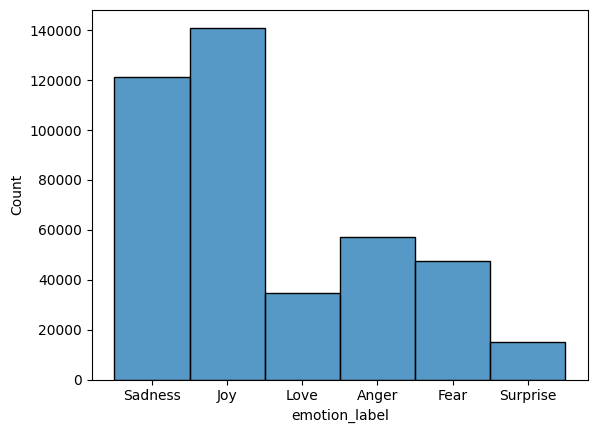

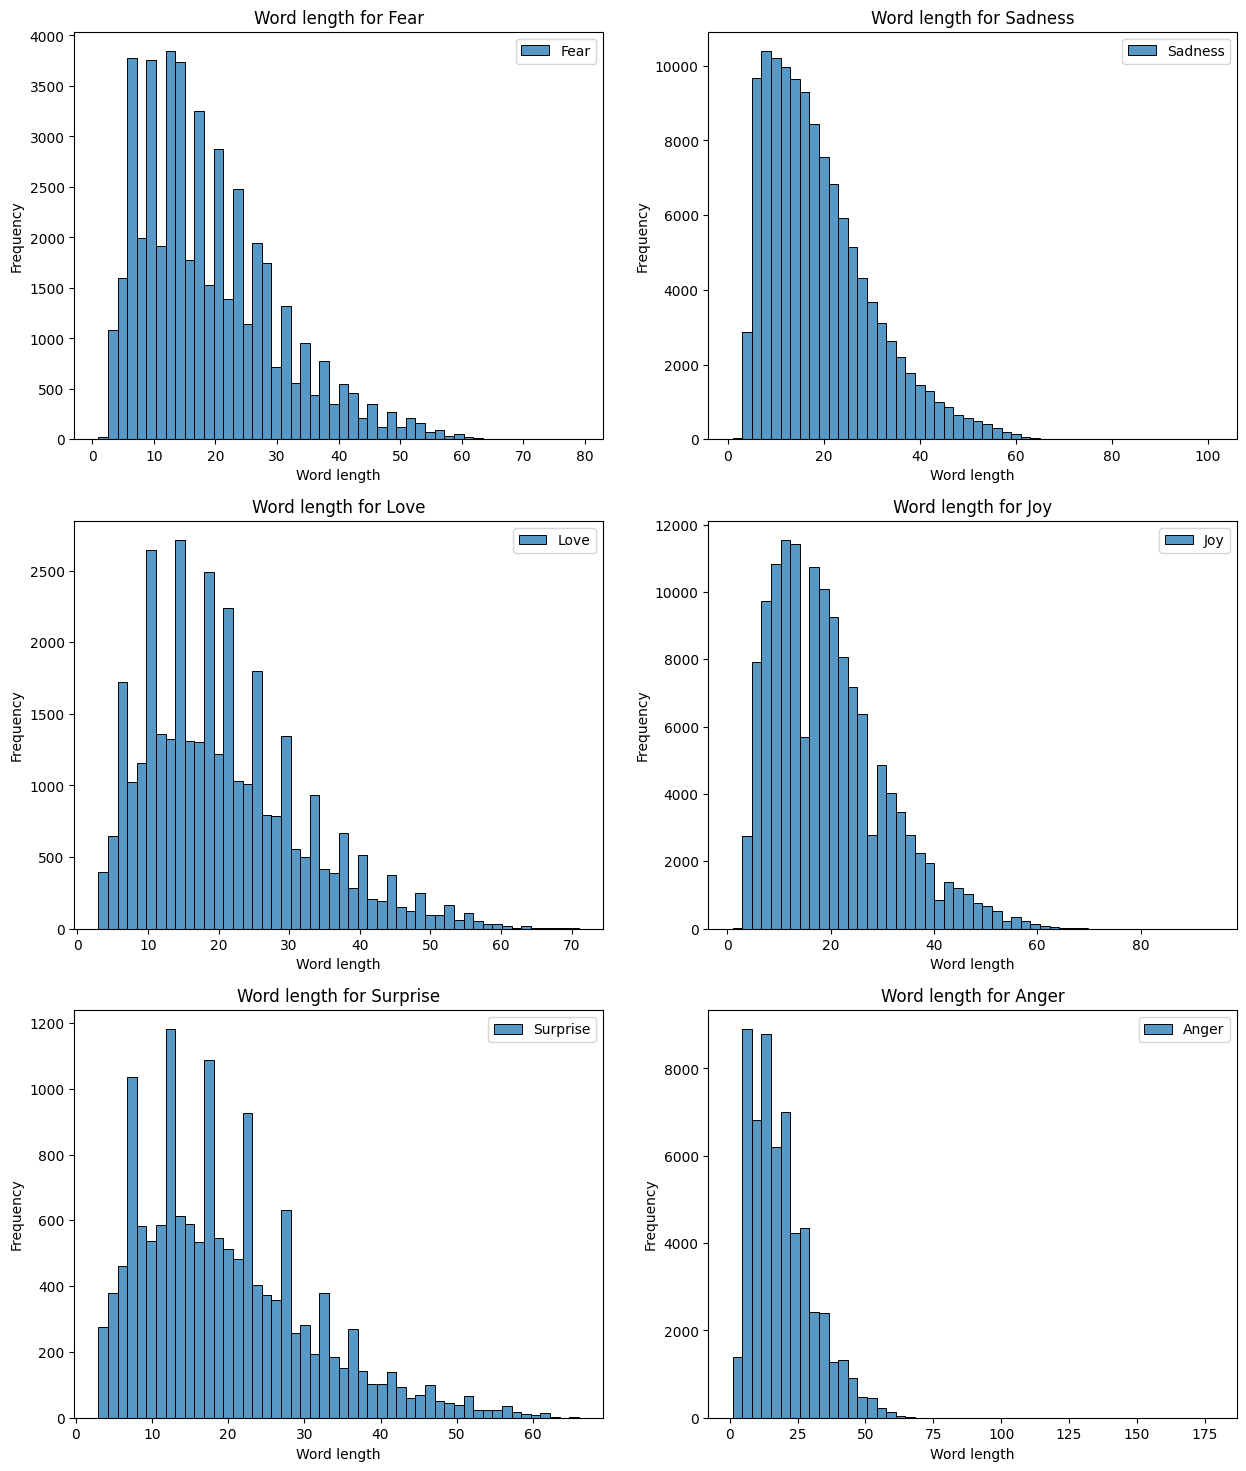

In [204]:
sns.histplot(data=emotion_dataset,x='emotion_label')
fig, axs =  plt.subplots(3,2, figsize = (15,18))
axs = axs.flatten()
for i, emotion in enumerate(list(emotion_dataset['emotion_label'].unique())):
    subplot = emotion_dataset[emotion_dataset['emotion_label'] == emotion]
    sns.histplot(data=subplot,
                 x = 'word_length',
                 ax=axs[i],
                 bins = 50)
    axs[i].set_title(f"Word length for {emotion}")
    axs[i].set_xlabel("Word length")
    axs[i].set_ylabel("Frequency")
    axs[i].legend([emotion])

## Data Preprocessing: Text proprocessing
- lowercase
- dealing with numbers, punctuation, and symbols
- splitting
- tokenizing
- removing "stopwords"
- lemmatizing

In [210]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jason/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jason/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jason/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [234]:
def basic_cleaning(sentence):
    sentence = sentence.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '')
        sentence = sentence.strip()
    return sentence

In [237]:
def preprocessing_text(text):
    text = text.str.lower()
    text = text.str.replace(r'http\S+', '', regex=True)
    text = text.str.replace(r'[^\w\s]', '', regex=True)
    text = text.str.replace(r'\s+', ' ', regex=True)
    text = text.str.replace(r'\d+', '', regex=True)
    text = text.str.strip()
    return text

def remove_stopwords(sentence):
    stop_words  = set(stopwords.words('english'))
    filtered_sentence = [word for word in sentence.split() if word not in stop_words]
    return ' '.join(filtered_sentence)

In [238]:
emotion_dataset['text'] = preprocessing_text(emotion_dataset['text'])
emotion_dataset['text'] = emotion_dataset['text'].apply(remove_stopwords)

In [239]:
emotion_dataset

,text,label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4
...,...,...
416804,feel like telling horny devils find site suite...,2
416805,began realize feeling agitated restless would ...,3
416806,feel curious previous early dawn time seek tro...,5
416807,feel becuase tyranical nature government el sa...,3
